The goal here is to realize a time-lapse using a raspberry π and some python code and finally get this:

![](https://github.com/laurentperrinet/TimeTeleScope/raw/main/videos/2021-02-17_TimeTeleScope.gif)

(This was done over 10 days, with *almost* each day an *irregular* session the morning and one in the evening)

<!-- TEASER_END -->

The code (and more) is also available @ https://github.com/laurentperrinet/TimeTeleScope

## data acquisition

This is well documented on the web and consisted in simply:

* setting up the raspberry π to use the camera
* create a startup script [`startup.sh`](https://github.com/laurentperrinet/TimeTeleScope/blob/main/startup.sh) (or clone this repo in `/home/pi` using `git clone https://github.com/laurentperrinet/TimeTeleScope)` consisting of the commands which take 2 successive frames at different exposures :
```
raspistill -rot 270 -ev -10 --metering spot -o /home/pi/Desktop/orchid/`date +%Y-%m-%d.%H:%M:%S`.jpg
raspistill -rot 270 -ev -8 --metering spot -o /home/pi/Desktop/orchid/`date +%Y-%m-%d.%H:%M:%S`.jpg
```
* run that script regularly (every ten minute) by adding the following line to the cron table (using `sudo crontab -e`):
```
*/10 * * * * /home/pi/TimeTelescope/startup.sh
```

* the π was placed next to the orchid flowers for more than one week.

The rest of this notebook transforms the sequence of frames into a movie.


# low-level utilities

In this first part, we:

 * set up parameters,
 * load images and display one,
 * perform a low-level filtering of the good versus bad images
 * todo: low-level re-alignment (seems not necessary as the camera did not move during the acquisition)

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2

In [4]:
def init(args=[], date=None, DEBUG=1):
    if date is None:
        import datetime
        # https://en.wikipedia.org/wiki/ISO_8601
        date = datetime.datetime.now().date().isoformat()
    tag = f'{date}_TimeTeleScope'

    import argparse
    # Training settings
    parser = argparse.ArgumentParser(description='TimeTeleScope')
    parser.add_argument('--tag', type=str, default=tag, help='unique ID to tag our results')
    parser.add_argument('--date', type=str, default=date, help='date of the run')
    parser.add_argument('--in-path', type=str, default='../orchid', help='Folder containing the raw images')
    parser.add_argument('--cache-path', type=str, default='cache_path', help='Folder to store intermediate images')
    parser.add_argument('--videos-path', type=str, default='videos', help='Folder to store the final video')
    parser.add_argument('--figwidth', type=float, default=15, help='Width of figures')
    parser.add_argument('--ds', type=int, default=1, help='downsampling factor')
    parser.add_argument('--fps', type=float, default=12, help='FPS of output gif')
    parser.add_argument('--verb', type=bool, default=0, help='to blah or not blah')
    args = parser.parse_args(args=[])

    return args

In [5]:
args = init()
args

Namespace(tag='2021-02-20_TimeTeleScope', date='2021-02-20', in_path='../orchid', cache_path='cache_path', videos_path='videos', figwidth=15, ds=1, fps=12, verb=0)

In [6]:
import os
class TimeTeleScopeLoad():
    def __init__(self, args):
        # saving parameters in the class
        self.args = args
        if self.args.verb : print(f'Tagging our simulations with tag={self.args.tag}')
            
        # creating folders
        os.makedirs(self.args.cache_path, exist_ok=True)
        os.makedirs(self.args.videos_path, exist_ok=True)
        # setting up figure size
        self.figsize = (self.args.figwidth, self.args.figwidth/phi)

    # IMAGE
    def glob(self, gex='*.jpg'):
        """
        Globs images in a folder.

        Images should have a jpg extension and
        be in JPG format.
        
        Returns a list of image filenames sorted alphabetically.
        """
        fnames = []

        import glob
        # https://stackoverflow.com/questions/6773584/how-is-pythons-glob-glob-ordered
        for fname in sorted(glob.glob(f'{self.args.in_path}/{gex}')):
            fnames.append(fname)

        return fnames

    
    def glob_and_load(self, gex='2021-02-14*.jpg'):
        """
        Globs images in a folder.

        Images should have a jpg extension and
        be in JPG format.
        
        Returns a list of images.
        """
        imgs = {}
        for fname in self.glob(gex=gex):
            imgs[fname] = self.process(fname, do_preprend=False)
        return imgs


    def process(self, fname):
        """
        Placeholder function for preprocessing images.
        
        It simply consists here in normalizing the 8-bits raw images to be in the [0, 1] range.
        
        """
        nx, ny, img = self.load(fname)
        if self.args.verb >= 20 : print('img min max', img.min(), img.max())
        return img/255.
    
    def load(self, fname):
        """
        Loads an image using openCV.

        """
        import cv2
        if self.args.verb : print(f'Loading {fname}')
        im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        # resample by resizing image
        nx, ny, three = im.shape
        if self.args.ds > 1:
            # CAREFUL ! for a strange reason openCV inverts H and W ??
            im = cv2.resize(im, (ny//self.args.ds, nx//self.args.ds),
                            interpolation = cv2.INTER_AREA)
            nx, ny, three = im.shape
        assert(three==3)
        return nx, ny, im


Instantiate the class:

In [7]:
ttl = TimeTeleScopeLoad(args)

In [8]:
fnames = ttl.glob()

In [9]:
print(f'{len(fnames)=}')

len(fnames)=684


# histogram matching

The main processing step for setting up the time lapse is to make images have a similar lightning and color balance to avoid any flicker due to different lighting conditions.

The idea here is to separate two pieces of information: the *palette* of the image which corresponds to the different tones and colors within the scene and which depend of the lighting conditions **versus** the shape of the scene which is encoded in the position of the individual pixels. To avoid flickering, on efficient method is to tranfer the palette of a reference image to each image of the palette, and this is called technically histogram matching.

This equalization of images is performed with respect to a reference image, using the code from https://github.com/scikit-image/scikit-image/blob/master/skimage/exposure/histogram_matching.py#L22-L70  :

In [4]:
import numpy as np

from skimage.exposure import match_histograms

def histMatch(sourceImage, templateImage):
    """
    Matches the histogram of sourceImage to the templateImage in order to fix lightness/exposure
    of the sourceImage.
    """
    return match_histograms(sourceImage, templateImage, multichannel=True)

Picking some image from the stack:

In [5]:
fname_reference = '../orchid/2021-02-14.22:10:07.jpg'
image_reference = ttl.process(fname_reference)

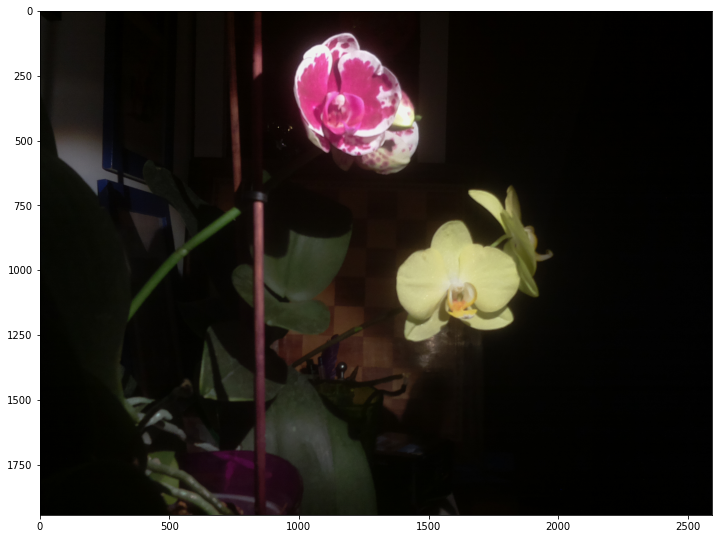

In [6]:
fig, ax = plt.subplots(figsize=ttl.figsize)
ax.imshow(image_reference, vmin=0, vmax=255);

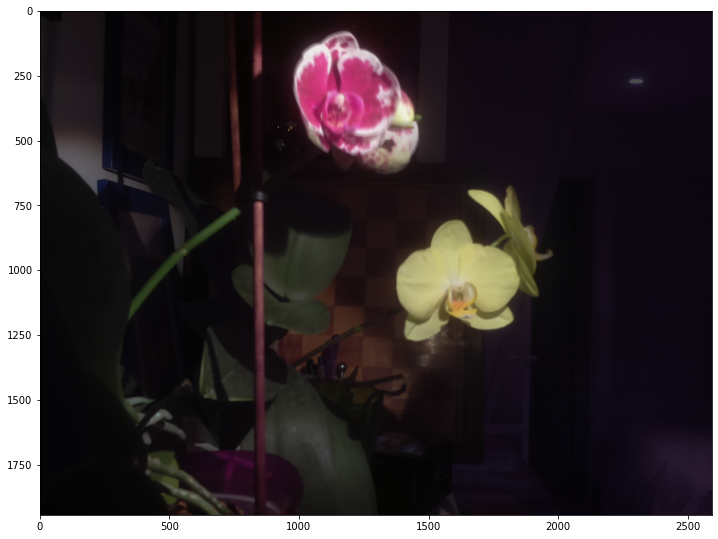

0.0020988677161005243 0.9690140845070422


In [7]:
count = 1
for fname in fnames:
    if '2021-02-14' in fname:
        image_reference += ttl.process(fname)
        count += 1
image_reference /= count

fig, ax = plt.subplots(figsize=ttl.figsize)
ax.imshow(image_reference)
plt.show();
print(image_reference.min(), image_reference.max())

Picking another image from the stack, showing the same scene but with a different exposure:

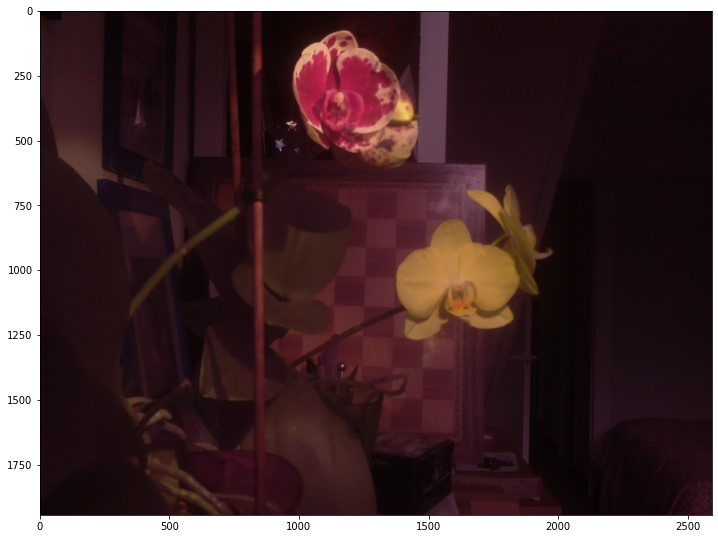

In [9]:
fname_new = '../orchid/2021-02-14.17:30:07.jpg'
fig, ax = plt.subplots(figsize=ttl.figsize)
ax.imshow(ttl.process(fname_new));

The matched image has a more similar aspect to the reference, while keeping its own arrangement:

0.008837337752002204 0.9690140845070422


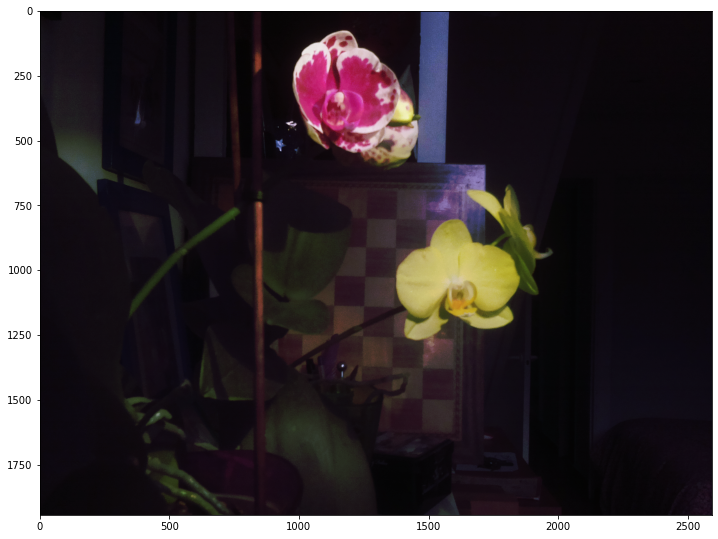

In [10]:
image_matched = histMatch(ttl.process(fname_new), image_reference)
fig, ax = plt.subplots(figsize=ttl.figsize)
ax.imshow(image_matched);

print(image_matched.min(), image_matched.max())

# processing the full stack into a movie

Now that we know how to match the images from the stack to some reference, we can process the whole stack and save the matched images into a cache folder:


In [3]:
fnames = ttl.glob()

In [4]:
frames = []
n_bits = 16 # precision for saving images

for i, fname_new in enumerate(fnames):
    # print(f'{fname_new=}')
    image_matched = histMatch(ttl.process(fname_new), image_reference)
    #print(image_matched.min(), image_matched.max())
    image_matched *= 2**n_bits-1
    image_matched = image_matched.astype(np.uint16)

    fname = f'{ttl.args.cache_path}/{ttl.args.tag}_{i}.png'
    
    import cv2
    cv2.imwrite(fname, cv2.cvtColor(image_matched, cv2.COLOR_RGB2BGR))

    frames.append(fname)
    

## Merging single frames 

We use the excellent [moviepy](https://pypi.org/project/moviepy/) library to convert the single frames into a movie:

In [5]:
import moviepy.editor as mpy
import moviepy.video.io.ImageSequenceClip
def make_mp4(moviename, frames, fps, do_delete=True):
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=fps)
    clip.write_videofile(moviename)
    if do_delete: 
        for frame in frames: os.remove(frame)
    return moviename

video_name = f'{ttl.args.videos_path}/{ttl.args.tag}.mp4'
make_mp4(video_name, frames, ttl.args.fps, do_delete=False)

t:   0%|          | 2/685 [00:00<00:36, 18.53it/s, now=None]

Moviepy - Building video videos/2021-02-21_TimeTeleScope.mp4.
Moviepy - Writing video videos/2021-02-21_TimeTeleScope.mp4



Moviepy - Done !
Moviepy - video ready videos/2021-02-21_TimeTeleScope.mp4


'videos/2021-02-21_TimeTeleScope.mp4'

Eventually, we can have a preview using:

In [6]:
#from IPython.display import Image, display
width = 1024

def show(filename, width=1024):
    from IPython.display import Video
    # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=IPython.display#IPython.display.Video
    return Video(filename, html_attributes=f"controls muted autoplay width={width}")

# show(video_name, width=1024)

Moreover, it's easy to generate a gif (with some downscaling to avoid having a huge file...):

In [8]:
def make_gif(gifname, frames, fps, ds=1, tds=1, do_delete=True):
    import imageio
    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for frame in frames[::tds]:
            img = imageio.imread(frame)
            if ds > 1:
                nx, ny, three = img.shape
                # CAREFUL ! for a strange reason openCV inverts H and W ??
                img = cv2.resize(img, (ny//ds, nx//ds),
                                interpolation = cv2.INTER_AREA)
                nx, ny, three = img.shape            
            writer.append_data(img)

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for frame in frames: os.remove(fname)
    return gifname

In [9]:
gif_name = f'{ttl.args.videos_path}/{ttl.args.tag}.gif'
make_gif(gif_name, frames, ttl.args.fps, ds=8, tds=4, do_delete=False)

'videos/2021-02-21_TimeTeleScope.gif'

Et voilà!

## some book keeping for the notebook

In [10]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,cv2,moviepy,skimage,matplotlib  -r -g -b

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

numpy     : 1.20.1
cv2       : 4.5.1
moviepy   : 1.0.3
skimage   : 0.18.1
matplotlib: 3.3.3

Compiler    : Clang 12.0.0 (clang-1200.0.32.29)
OS          : Darwin
Release     : 20.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: ekla

Git hash: 306725c1778bf4d3cb07172966b8af9432172dee

Git repo: https://github.com/laurentperrinet/TimeTeleScope

Git branch: main

